In [1]:
%run -i XAI.py

In [2]:
def read_tabular_data(file_name,base_dir):
    df      = os.path.join(base_dir,file_name)
    df_read = pd.read_csv(df, thousands=r',')                                   
    return df_read

def data_reader_Comal(file_name,base_dir, skip_rows):
    df      = os.path.join(base_dir,file_name)
    df_read = pd.read_csv(df, thousands=r',', skiprows = skip_rows) 
    return df_read

## Give the path to save the file 

In [3]:
import os
save_Model = create_folder_to_save('/Catboost_untuned')
#save_Model = make_path_to_save(Results,'XGBoost')
save_features = make_path_to_save(save_Model,'Features_importance')
saveRCP_45 = make_path_to_save(save_Model,'RCP45')
saveRCP_85 = make_path_to_save(save_Model,'RCP85')

In [4]:
#Importing the SA Intl climate data
base_dir = os.getcwd()
###################################################################################################
###################################################################################################
filename = r"Input_Data/Daily Precipitation and Temperature - San Antonio TX Intl Airport from Sep 1 1946 to Nov 29 2020.csv"
df_hist_climate = read_tabular_data(filename, base_dir)

df_hist_climate.index = pd.DatetimeIndex(df_hist_climate['DATE'])

In [5]:

df_hist_climate_NOAA = pd.DataFrame()
df_hist_climate_NOAA['$T_{min}$ [$^oC$]'] = ((pd.to_numeric(df_hist_climate['DAILY MIN TEMP (DEG F)'], errors='coerce').values) - 32)*5/9
df_hist_climate_NOAA['$T_{max}$ [$^oC$]'] = ((pd.to_numeric(df_hist_climate['DAILY MAX TEMP (DEG F)'], errors='coerce').values) - 32)*5/9
df_hist_climate_NOAA['$P$ [mm]'] = (pd.to_numeric(df_hist_climate['DAILY PRECIPITATION (inches)'], errors='coerce').values)*25.4
df_hist_climate_NOAA.index = df_hist_climate.index
# df_hist_climate_NOAA
df_AI = pd.DataFrame()

df_AI['$T_{min}$ [$^oC$]'] = df_hist_climate_NOAA['$T_{min}$ [$^oC$]'].resample('W').mean()
df_AI['$T_{max}$ [$^oC$]'] = df_hist_climate_NOAA['$T_{max}$ [$^oC$]'].resample('W').mean()
df_AI['$P$ [mm]'] = df_hist_climate_NOAA['$P$ [mm]'].resample('W').sum()
df_AI.describe()

,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm]
count,3875.000000,3875.000000,3875.000000
mean,14.749042,26.796088,14.946802
std,7.595685,7.133037,28.066030
min,-8.968254,1.111111,0.000000
25%,8.333333,21.349206,0.000000
50%,15.555556,27.539683,3.302000
75%,22.063492,32.857143,18.034000
max,26.428571,39.761905,383.794000


# Comal Springs

In [6]:
# -- Comal Springs Data 
skip_rows = 30
base_dir  = os.getcwd() +'/Input_Data/'
filename  = r"Daily_SpringDischarge_Comal_Spring.csv"
#------
Comal_Spring_Flow_or = data_reader_Comal(filename, base_dir, skip_rows)
Comal_Spring_Flow_or  

Comal_Spring_Flow = []
Comal_Spring_Flow = Comal_Spring_Flow_or[['20d', '14n']].copy()
Comal_Spring_Flow = Comal_Spring_Flow.rename(columns = {'20d' : 'Date', '14n' : 'SF(cfs)'})

Comal_Spring_Flow['Date']  =  pd.to_datetime(Comal_Spring_Flow['Date'])
Comal_Spring_Flow['SF$[m^3/s]$'] = round(Comal_Spring_Flow['SF(cfs)'].astype(float)*0.028316847, 3)
Comal_Spring_Flow.drop(index=0,inplace=True)

Comal_Spring_Flow.index = pd.DatetimeIndex(Comal_Spring_Flow['Date'])
Comal_Spring_Flow.drop('Date',axis =1,inplace=True)

#Comal_Spring dataframe
Comal_Spring_Flow
#####
df_numeric_values_Cml = pd.to_numeric(Comal_Spring_Flow['SF$[m^3/s]$'], errors='coerce')

Comal_sf_data = df_numeric_values_Cml.to_frame()


#Data is Transformed to  Monthly mean from daily data and truncated 
SF_Data = Comal_sf_data.resample('W').mean()
SF_Data


#df_AI = (df_AI[(df_AI.index >= '1956-05-27') & (df_AI.index <= '2020-06-07')])
#df_AI

df_AI['SF$[m^3/s]$'] = (SF_Data[(SF_Data.index >= '1946-09-01')& (SF_Data.index <= '2020-11-29')])

df_AI = df_AI[(df_AI.index >= '1960-09-01')]
df_AI.describe()



,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm],SF$[m^3/s]$
count,3144.000000,3144.000000,3144.000000,3144.000000
mean,14.817087,26.793792,15.454413,8.277359
std,7.629288,7.103033,28.606174,2.412999
min,-6.666667,1.111111,0.000000,0.750000
25%,8.333333,21.507937,0.000000,6.642143
50%,15.674603,27.539683,3.556000,8.493071
75%,22.142857,32.777778,19.050000,10.032321
max,26.428571,39.761905,383.794000,14.401000


In [7]:
# Pumping patterns is hypothesized to be associated with the month
df_AI['Month'] = df_AI.index.month 

# Create lag
df_AI['$T_{max}^{lag1}$ [$^oC$]'] = df_AI['$T_{max}$ [$^oC$]'].shift(1)
df_AI['$T_{max}^{lag2}$ [$^oC$]'] = df_AI['$T_{max}$ [$^oC$]'].shift(2)

df_AI['$T_{min}^{lag1}$ [$^oC$]'] = df_AI['$T_{min}$ [$^oC$]'].shift(1)
df_AI['$T_{min}^{lag2}$ [$^oC$]'] = df_AI['$T_{min}$ [$^oC$]'].shift(2)

df_AI['$P^{lag1}$ [mm]'] = df_AI['$P$ [mm]'].shift(1)
df_AI['$P^{lag2}$ [mm]'] = df_AI['$P$ [mm]'].shift(2)

df_AI['SF$^{lag1} [m^3/s]$'] = df_AI['SF$[m^3/s]$'].shift(1)
df_AI['SF$^{lag2} [m^3/s]$'] = df_AI['SF$[m^3/s]$'].shift(2)

df_AI.dropna(inplace=True)


In [8]:

Features = ['Month','$T_{min}$ [$^oC$]','$T_{max}$ [$^oC$]','$P$ [mm]',
            '$P^{lag1}$ [mm]','$P^{lag2}$ [mm]',
            'SF$^{lag1} [m^3/s]$','SF$^{lag2} [m^3/s]$']

#SpringFlow for Comal = Target
Target = ['SF$[m^3/s]$']


#Take the tain set till 2005 and test set from 2006 till 2020

df_AI_Train = df_AI[:'2008-12-31']
df_AI_Test = df_AI['2009-01-01':]

#Create Independent and dependent variable for machine learning
X = df_AI[Features].to_numpy()
Y = df_AI[Target].to_numpy()

In [9]:
train_X = df_AI_Train[Features].to_numpy()
train_y = df_AI_Train[Target].to_numpy()
test_X = df_AI_Test[Features].iloc[0].to_numpy().reshape(1, -1)



# Train and Test the model

Learning rate set to 0.047381
0:	learn: 2.2995672	total: 46.8ms	remaining: 46.8s
1:	learn: 2.2088493	total: 47.8ms	remaining: 23.9s
2:	learn: 2.1176103	total: 49.2ms	remaining: 16.3s
3:	learn: 2.0355900	total: 50ms	remaining: 12.4s
4:	learn: 1.9542403	total: 50.7ms	remaining: 10.1s
5:	learn: 1.8742977	total: 51.3ms	remaining: 8.5s
6:	learn: 1.7963019	total: 52ms	remaining: 7.38s
7:	learn: 1.7266700	total: 52.7ms	remaining: 6.54s
8:	learn: 1.6563699	total: 53.6ms	remaining: 5.9s
9:	learn: 1.5878998	total: 54.5ms	remaining: 5.39s
10:	learn: 1.5244606	total: 55.3ms	remaining: 4.97s
11:	learn: 1.4634302	total: 56.6ms	remaining: 4.66s
12:	learn: 1.4050990	total: 57.5ms	remaining: 4.36s
13:	learn: 1.3523692	total: 58.3ms	remaining: 4.1s
14:	learn: 1.2981824	total: 59ms	remaining: 3.88s
15:	learn: 1.2481475	total: 59.9ms	remaining: 3.68s
16:	learn: 1.1987057	total: 60.7ms	remaining: 3.51s
17:	learn: 1.1530784	total: 61.4ms	remaining: 3.35s
18:	learn: 1.1123786	total: 62.2ms	remaining: 3.21s
1

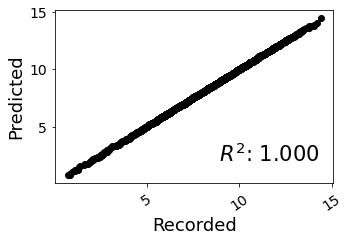

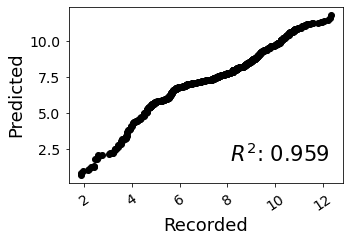

In [10]:
from catboost import CatBoostRegressor
Model = CatBoostRegressor()
Model.fit(train_X, train_y)
print_results(Model, train_X, train_y, save_Model)


In [11]:

Model.fit(X, Y)

Learning rate set to 0.049061
0:	learn: 2.3095574	total: 1.12ms	remaining: 1.12s
1:	learn: 2.2136891	total: 2.23ms	remaining: 1.11s
2:	learn: 2.1181926	total: 3.6ms	remaining: 1.2s
3:	learn: 2.0329870	total: 4.76ms	remaining: 1.19s
4:	learn: 1.9471044	total: 6.26ms	remaining: 1.25s
5:	learn: 1.8644500	total: 7.33ms	remaining: 1.21s
6:	learn: 1.7855842	total: 8.7ms	remaining: 1.23s
7:	learn: 1.7133040	total: 10ms	remaining: 1.24s
8:	learn: 1.6407726	total: 11.2ms	remaining: 1.23s
9:	learn: 1.5705854	total: 12.5ms	remaining: 1.23s
10:	learn: 1.5063749	total: 13.8ms	remaining: 1.24s
11:	learn: 1.4419924	total: 15.1ms	remaining: 1.24s
12:	learn: 1.3820985	total: 17.2ms	remaining: 1.31s
13:	learn: 1.3254584	total: 18.8ms	remaining: 1.32s
14:	learn: 1.2723673	total: 20ms	remaining: 1.31s
15:	learn: 1.2211216	total: 21.4ms	remaining: 1.32s
16:	learn: 1.1706113	total: 22.7ms	remaining: 1.31s
17:	learn: 1.1243363	total: 24ms	remaining: 1.31s
18:	learn: 1.0829759	total: 26.6ms	remaining: 1.37s
1

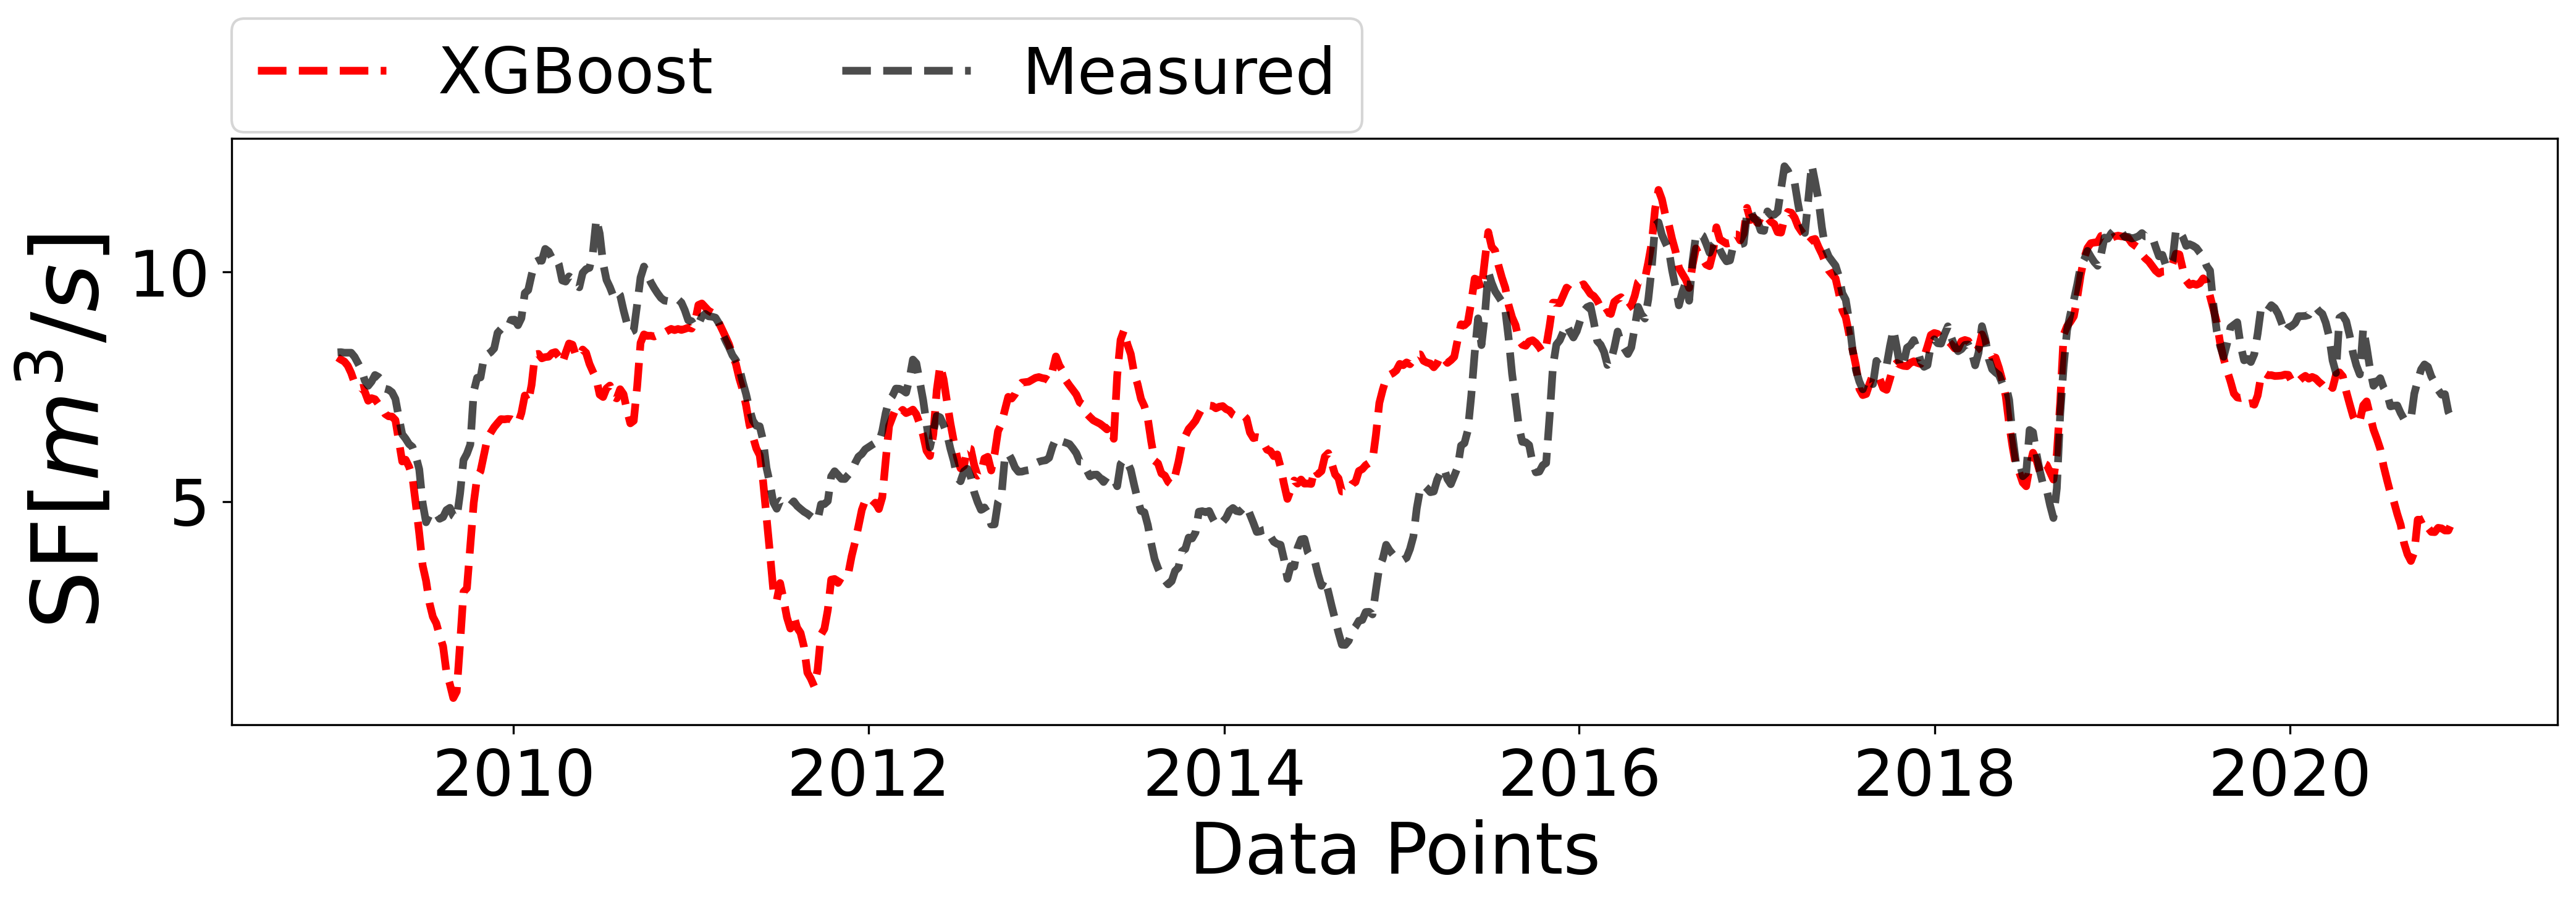

In [12]:
plot_test(df_AI_Test, save_Model, "XGBoost")

# Shapley analysis

In [13]:
import numpy as np
import pandas as pd
import xgboost as xgb
import datatable as dt # data table factory
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import explainerdashboard as expdb
from explainerdashboard import RegressionExplainer, ExplainerDashboard
from explainerdashboard import InlineExplainer
from explainerdashboard.custom import (ImportancesComposite,
                                       IndividualPredictionsComposite,
                                       WhatIfComposite,
                                       ShapDependenceComposite,
                                       ShapInteractionsComposite,
                                       DecisionTreesComposite)

In [14]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

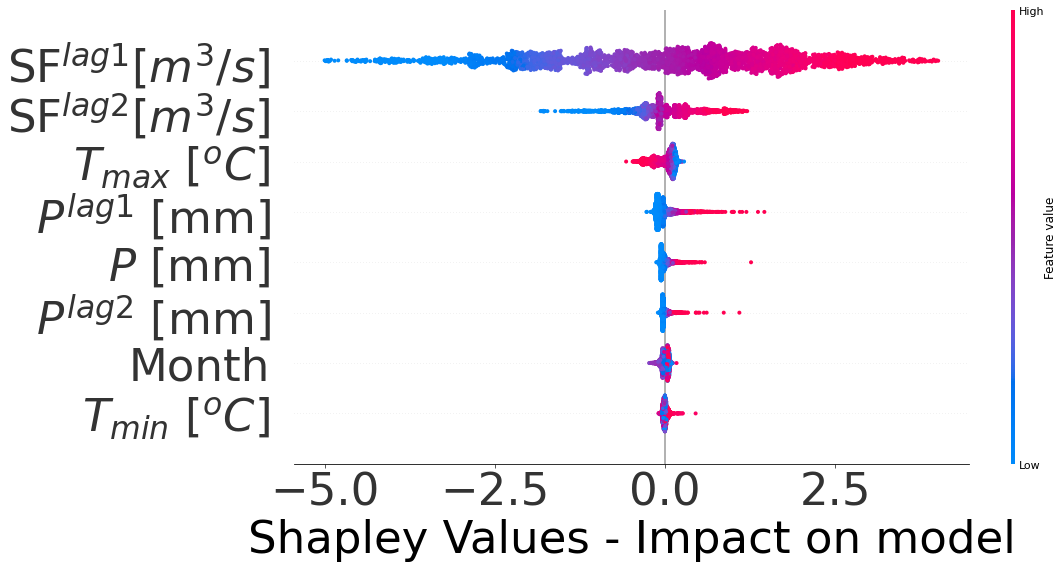

In [15]:
explainer = shap.TreeExplainer(Model)
shap_values = explainer.shap_values(df_AI[Features].to_numpy())

shap.summary_plot(shap_values, df_AI[Features].to_numpy(), Features, plot_size=(16,8), show=False)
plt.xlabel('Shapley Values - Impact on model', fontsize=45)
plt.tick_params(labelsize=45)
plt.tight_layout(pad=1.08)
plt.savefig(save_features +str('/Feature Importance - SF.pdf'), format='jpeg', dpi=300, bbox_inches ='tight')

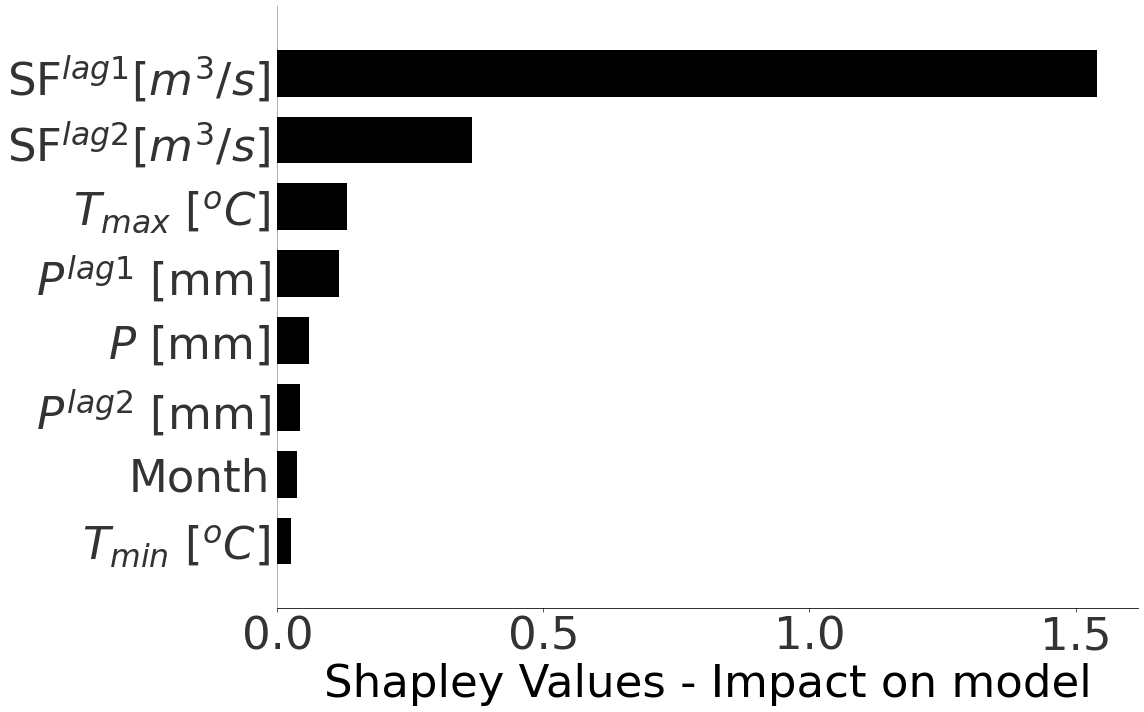

In [16]:

explainer = shap.TreeExplainer(Model)
shap_values = explainer.shap_values(df_AI[Features].to_numpy())

shap.summary_plot(shap_values, df_AI[Features].to_numpy(), Features, plot_size=(16,10), show=False, 
                  plot_type = "bar", color = "black")
plt.xlabel('Shapley Values - Impact on model', fontsize=45)
plt.tick_params(labelsize=45)
plt.tight_layout(pad=1.08)
plt.savefig(save_features + str('/Feature Importances - SF_- Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


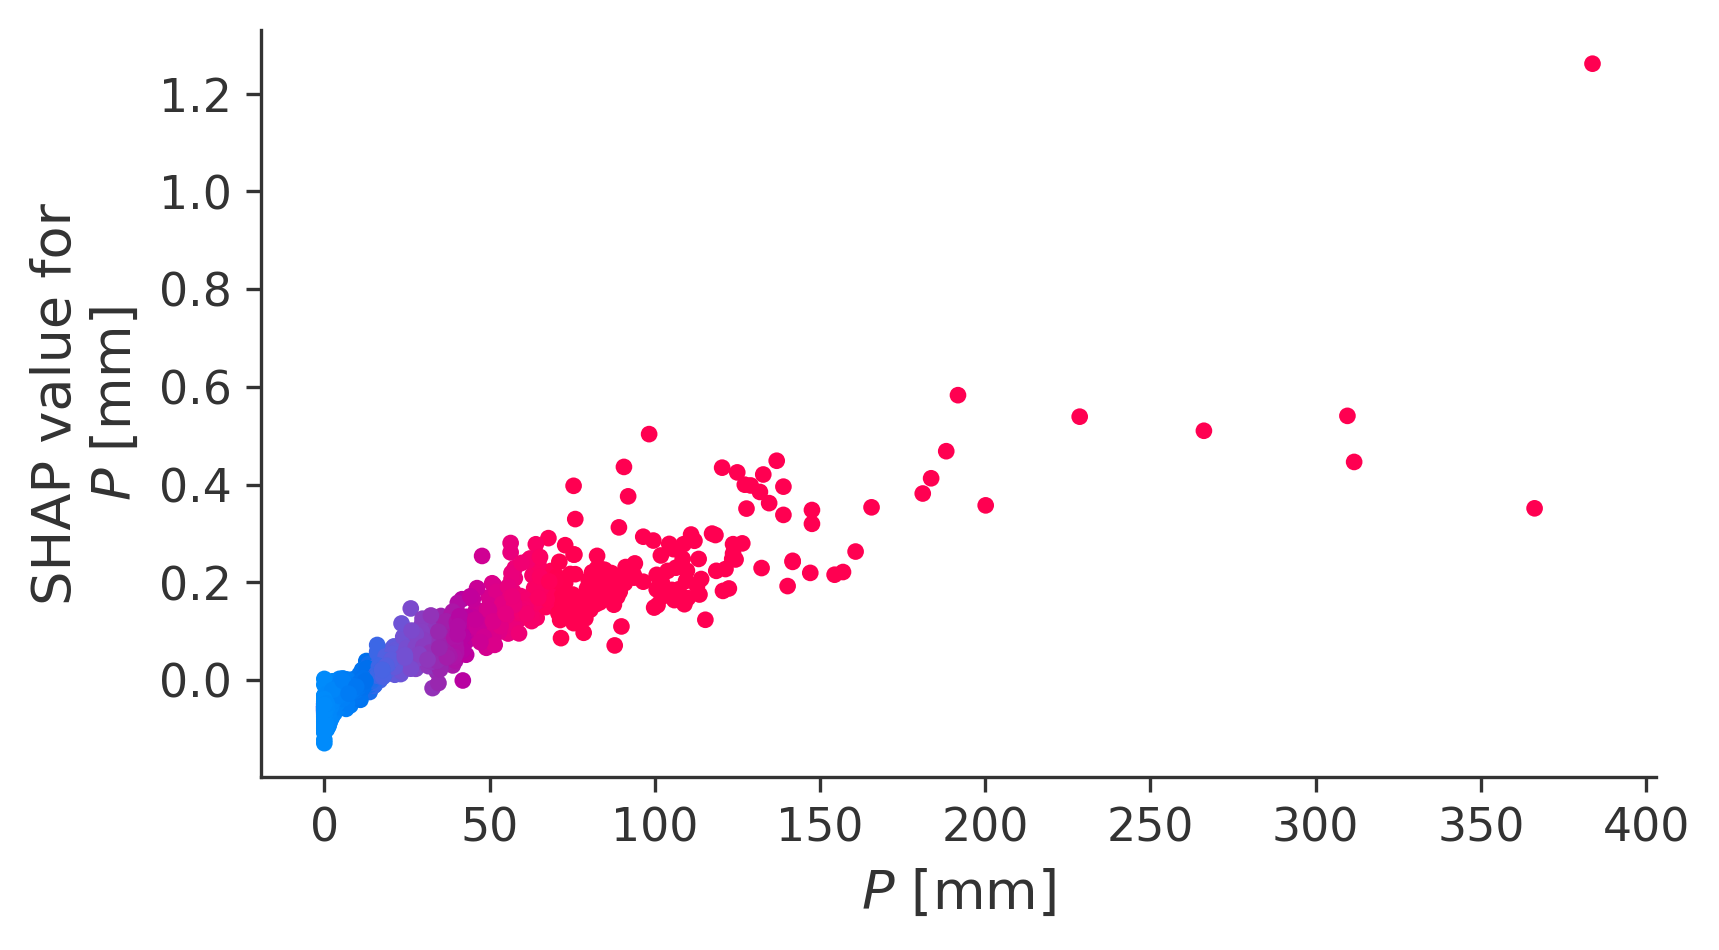

In [17]:
fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot('$P$ [mm]',shap_values, df_AI[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index='$P$ [mm]')
plt.savefig(save_features +str('/Pr -.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


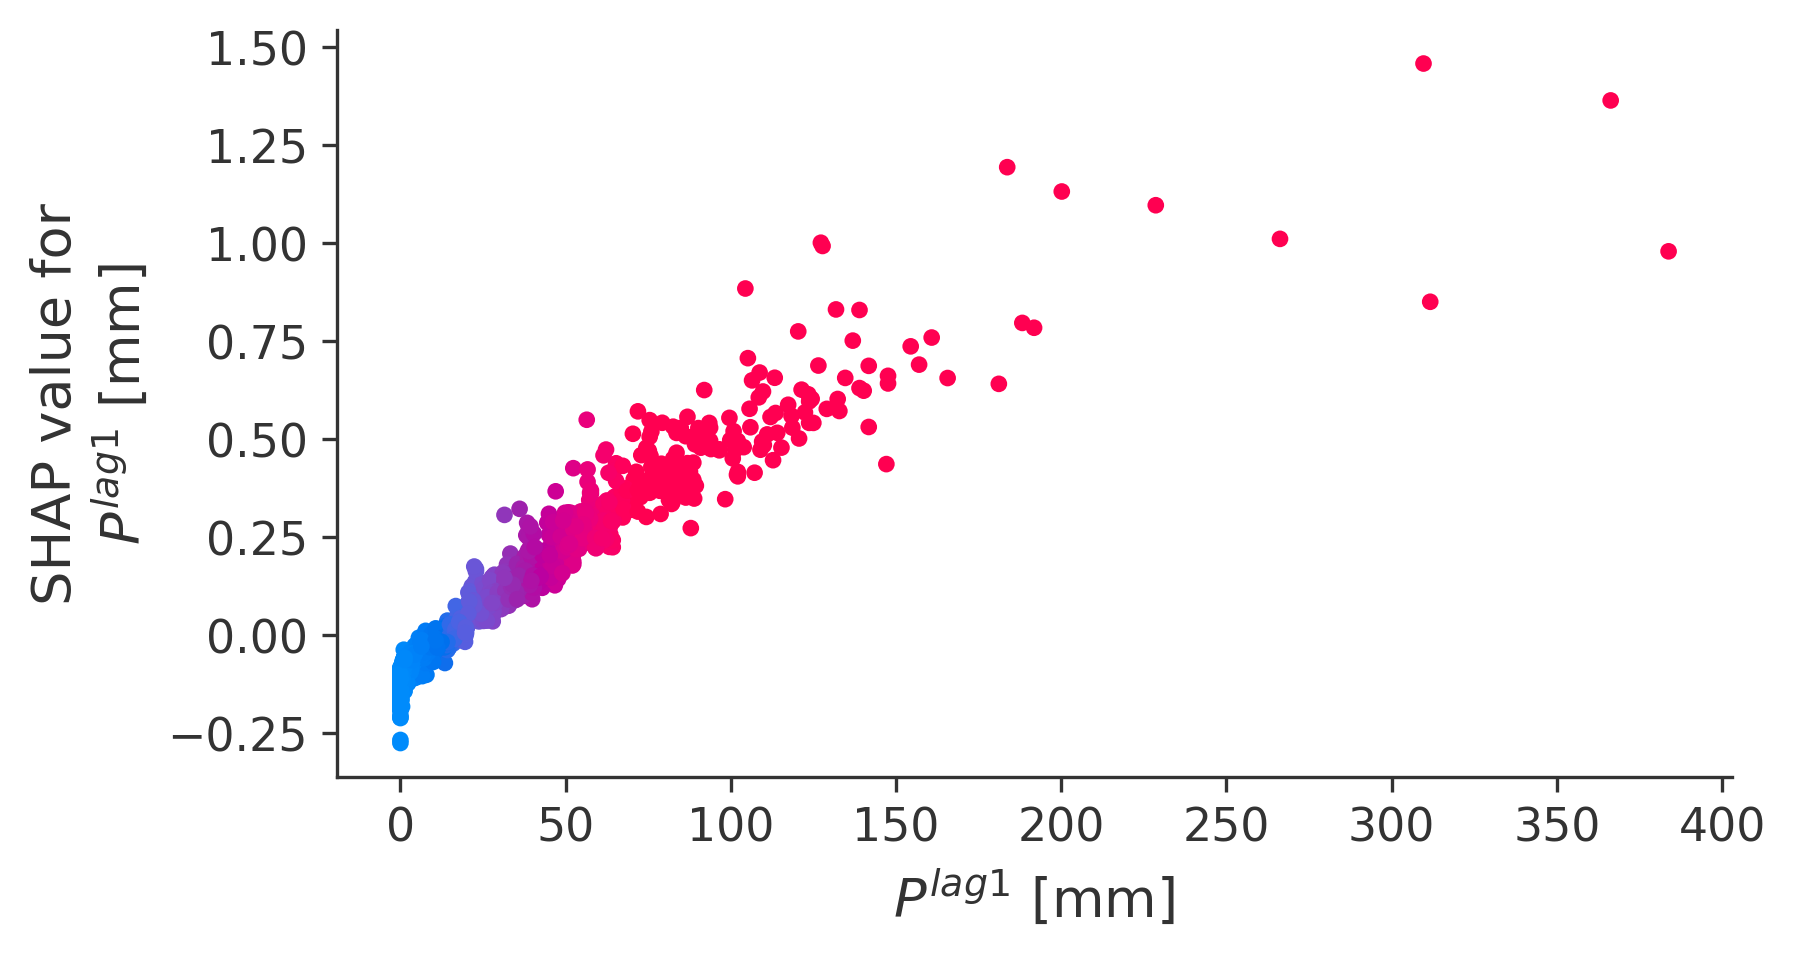

In [18]:
fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot( '$P^{lag1}$ [mm]',shap_values, df_AI[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index= '$P^{lag1}$ [mm]')
plt.savefig(save_features +str('/Prlag1 -.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


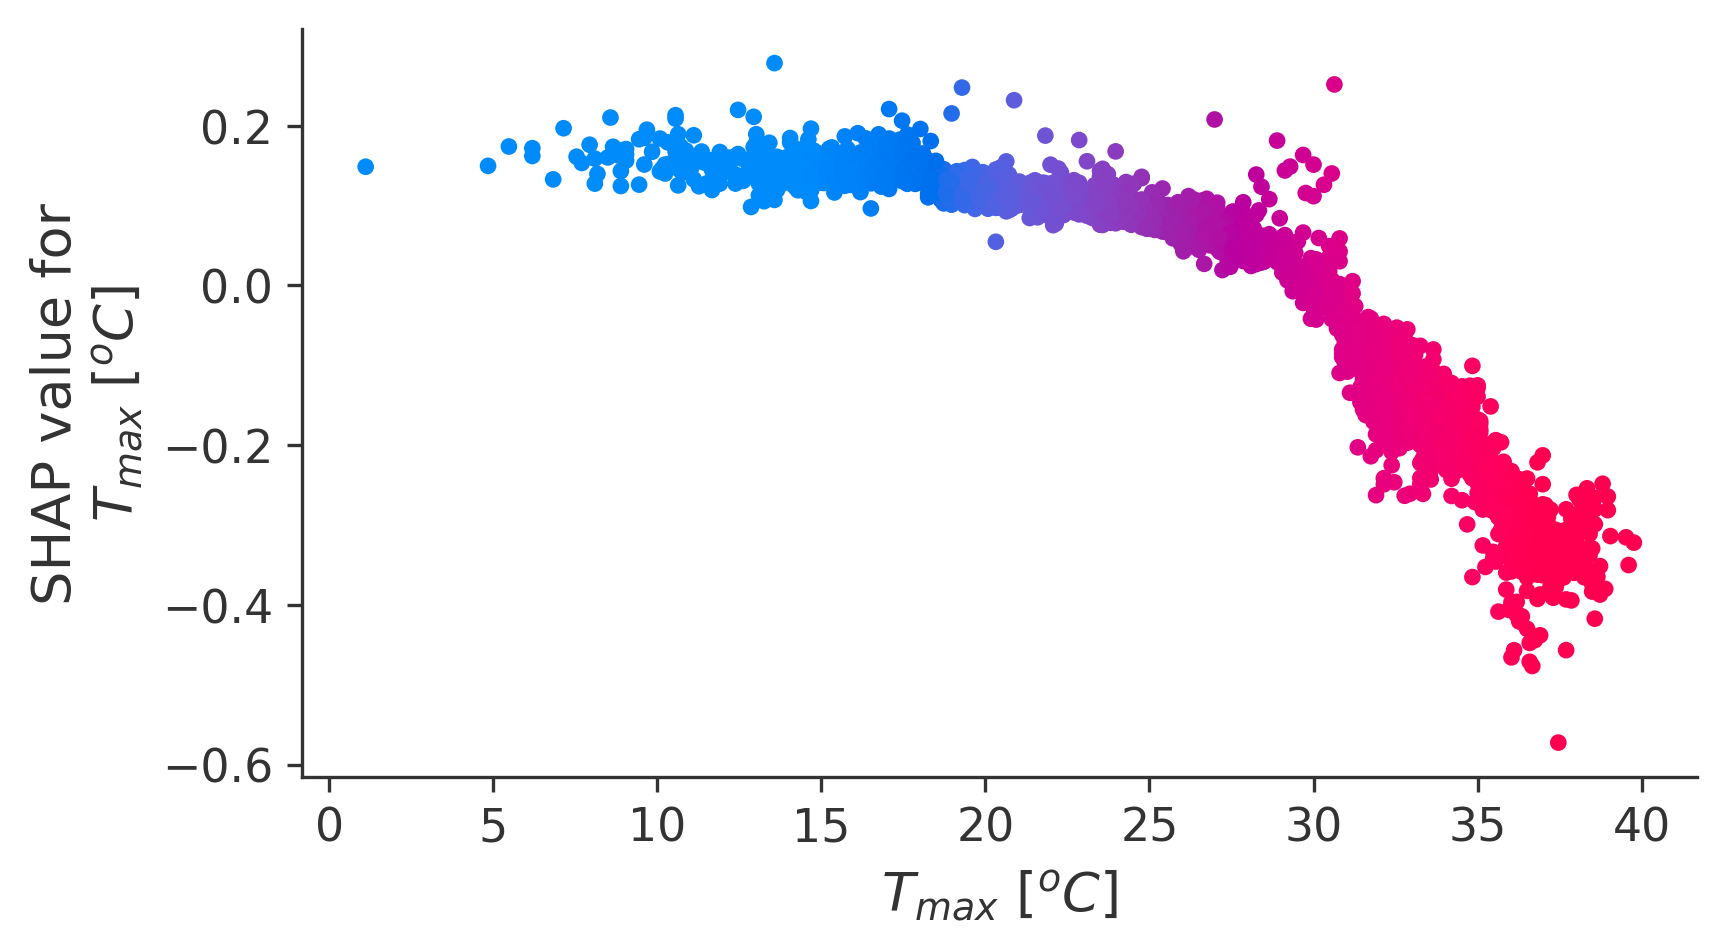

In [19]:

fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot('$T_{max}$ [$^oC$]', shap_values, df_AI[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index='$T_{max}$ [$^oC$]')
plt.savefig(save_features +str('/Tmax - Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


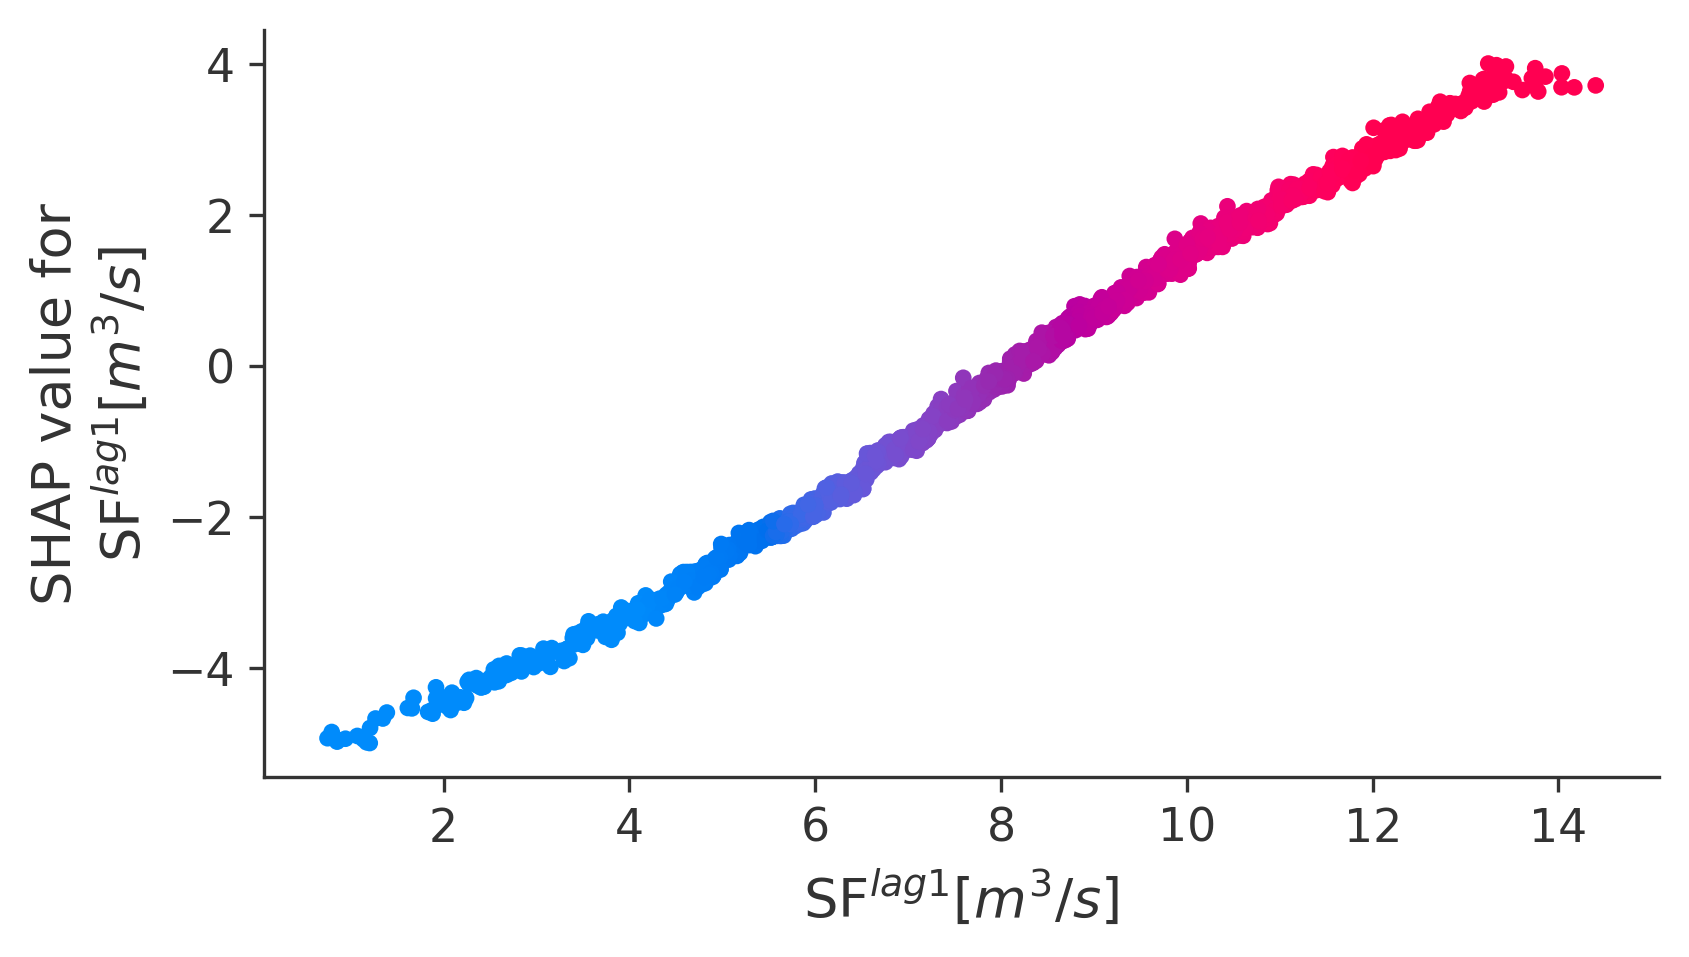

In [20]:

fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot('SF$^{lag1} [m^3/s]$',shap_values, df_AI[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index='SF$^{lag1} [m^3/s]$')
plt.savefig(save_features+str('/SF_Lag1 Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')




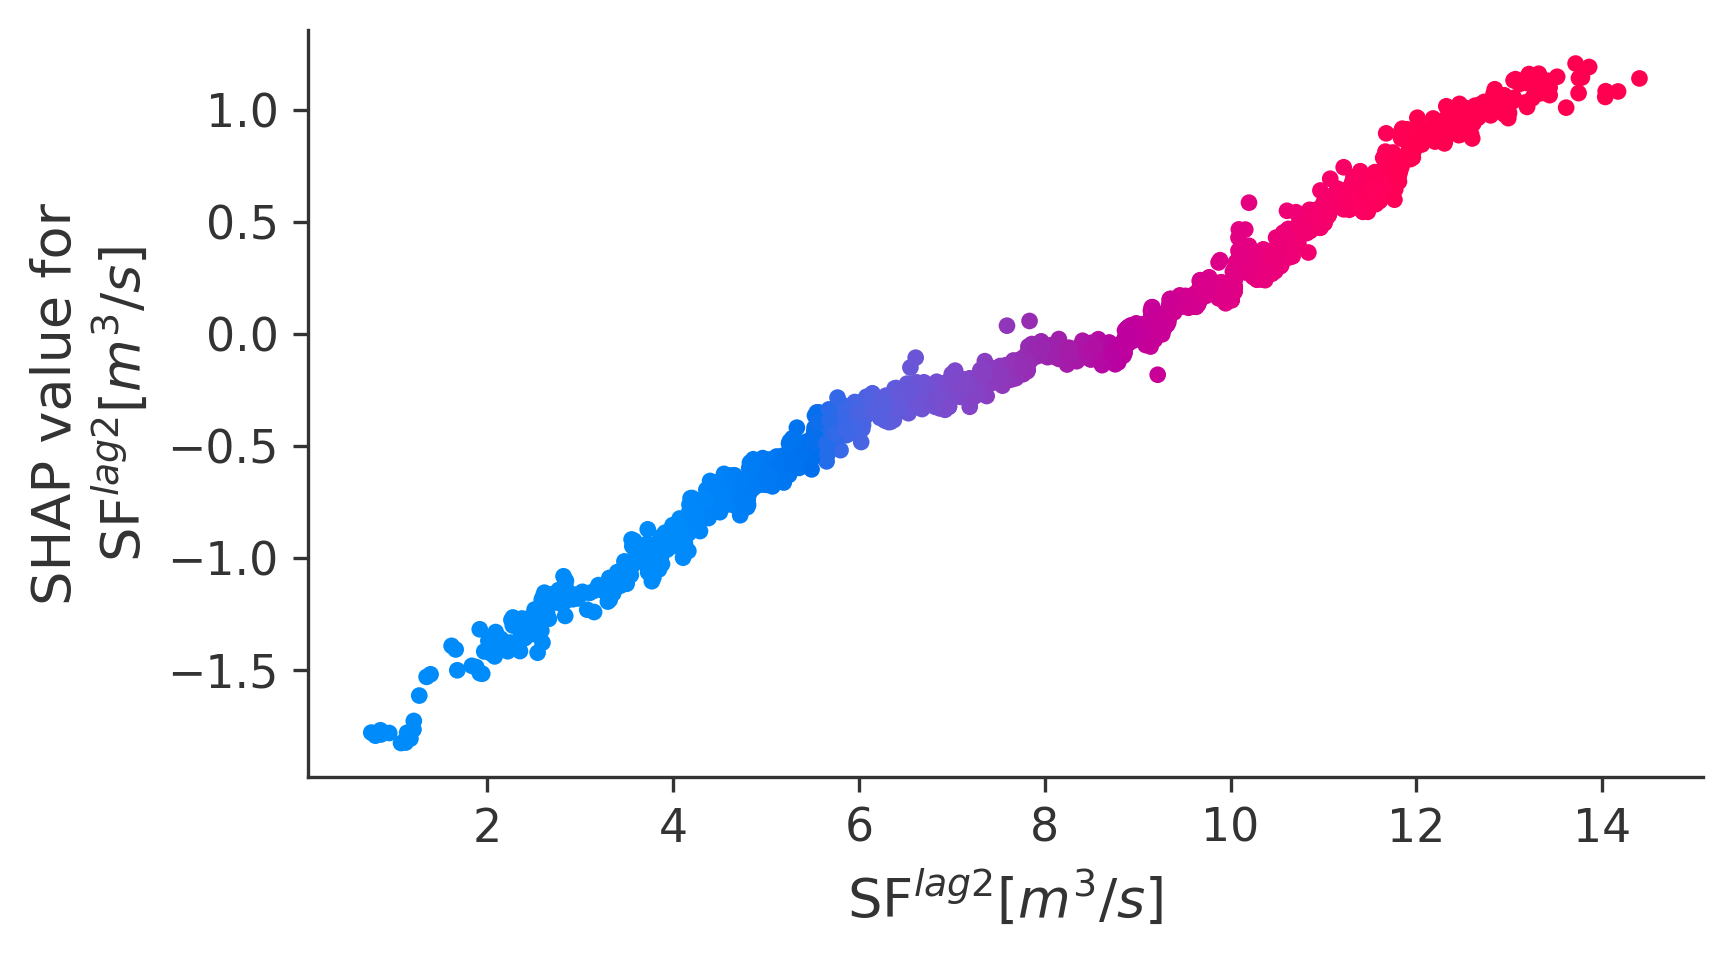

In [21]:
fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot('SF$^{lag2} [m^3/s]$',shap_values, df_AI[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index='SF$^{lag2} [m^3/s]$')
plt.savefig(save_features +str('/SF_Lag2 Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


In [22]:
df_AI.to_excel(save_Model +'/df_AI.xlsx')

In [25]:
def read_data(file_name,base_dir, num_skip_rows):
    df      = os.path.join(base_dir,file_name)
    df_read = pd.read_csv(df, thousands=r',',low_memory=False, skiprows = num_skip_rows)  
    return df_read

def MACA_data(base_dir, file_name):
    data_M_Hist  = []
    data_M_Hist  = read_data(file_name,base_dir, num_skip_rows)

    data_M_Hist.rename(columns = {data_M_Hist.columns[0] : 'Date',     data_M_Hist.columns[1] : 'Tmin[K]', 
                                  data_M_Hist.columns[2] : 'Tmax[K]' , data_M_Hist.columns[3] : 'Precip[mm]'}, \
                                  inplace = True)

    data_M_Hist['Tmin[C]'] = (data_M_Hist['Tmin[K]'] - 273.15).astype(float)
    data_M_Hist['Tmax[C]'] = (data_M_Hist['Tmax[K]'] - 273.15).astype(float)

    data_M_Hist['Tmin[C]'].interpolate(method = 'linear', limit_direction = 'both', inplace =True)
    data_M_Hist['Tmax[C]'].interpolate(method = 'linear', limit_direction = 'both', inplace =True)
    data_M_Hist['Precip[mm]'].interpolate(method = 'linear', limit_direction = 'both', inplace =True)
    return data_M_Hist

num_skip_rows =12
#-------------------------
# RCP 4.5 - M1-Tmax; M5-Precip; M16-Tmin
#-------------------------
base_dir  = os.getcwd()+r"/Input_Data/Downscaled_MACA_Climate_Data/M16_MIROC5_Japan"
file_name = r"RCP_4_5/data.csv"
temp = MACA_data(base_dir, file_name)

df_MACA_RCP45 = pd.DataFrame()
df_MACA_RCP45[['Date','$T_{max}$ [$^oC$]']] = temp[['Date','Tmax[C]']]
df_MACA_RCP45.index = pd.DatetimeIndex(df_MACA_RCP45['Date'])
df_MACA_RCP45.drop(['Date'],axis=1,inplace=True)


base_dir = os.getcwd()+r"/Input_Data/Downscaled_MACA_Climate_Data/M5_CCSM4_USA"
file_name = r"RCP_4_5/data.csv"
temp = MACA_data(base_dir, file_name)
df_MACA_RCP45['$P$ [mm]'] = temp['Precip[mm]'].values


base_dir = os.getcwd()+r"/Input_Data/Downscaled_MACA_Climate_Data/M20_NorESM1_M_Norway"
file_name = r"RCP_4_5/data.csv"
temp = MACA_data(base_dir, file_name)
df_MACA_RCP45['$T_{min}$ [$^oC$]'] = temp['Tmin[C]'].values


df_RCP45_MACA = pd.DataFrame()
df_RCP45_MACA['$T_{min}$ [$^oC$]'] = df_MACA_RCP45['$T_{min}$ [$^oC$]'].resample('W').mean()
df_RCP45_MACA['$T_{max}$ [$^oC$]'] = df_MACA_RCP45['$T_{max}$ [$^oC$]'].resample('W').mean().values
df_RCP45_MACA['$P$ [mm]'] = df_MACA_RCP45['$P$ [mm]'].resample('W').sum().values
df_RCP45_MACA.describe()


,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm]
count,4906.000000,4906.000000,4906.000000
mean,16.267201,29.449579,15.909449
std,7.614883,7.466808,30.876179
min,-6.800552,2.217379,0.000000
25%,9.809292,23.725248,0.487135
50%,17.204996,30.375417,4.444767
75%,23.368207,35.634299,18.378493
max,30.541171,47.351195,553.350795


############ Model Validation set Accuracy RCP 4.5###########
MAE: 0.460 m/s^3
NSE: 0.936
RMS: 0.584 m/s^3
R-squared: 0.936
########################################
 
########################################
 


,Month,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm],SF$[m^3/s]$
count,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000
mean,6.521904,16.307442,29.513812,15.915394,5.778466
std,3.448643,7.620982,7.471514,31.057825,2.221053
min,1.000000,-6.800552,2.217379,0.000000,1.277227
25%,4.000000,9.844935,23.770950,0.485398,4.150931
50%,7.000000,17.239967,30.485734,4.426141,5.721048
75%,10.000000,23.431822,35.682369,18.300679,7.194954
max,12.000000,30.541171,47.351195,553.350795,11.655721


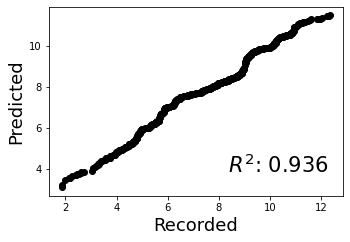

In [26]:
######## RCP(rcp_dataframe,df_AI, model, scenerio, save_to)
Approved_date = '2020-11-30'
df_future_45= RCP(df_RCP45_MACA,df_AI,Model, 4.5, saveRCP_45)
df_future_45.to_excel(saveRCP_45+str('/df_future_RCP45.xlsx'))
df_future_45.describe()

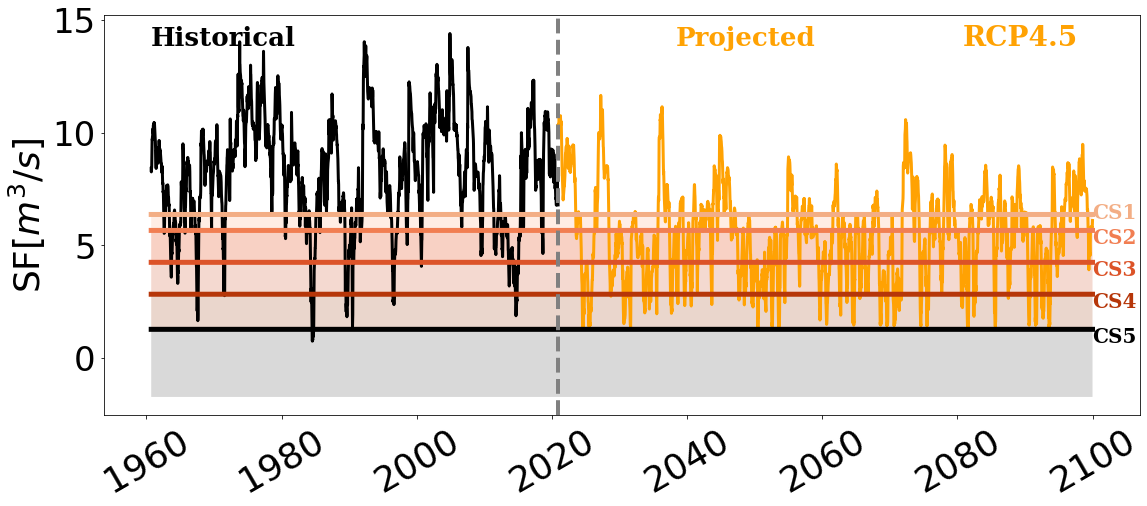

In [27]:
plot_projections(df_future_45,df_AI,4.5,saveRCP_45)

## RCP 8.5

In [28]:
#-------------------------
# RCP 8.5 - M1-Tmax; M5-Precip; M16-Tmin
#-------------------------
base_dir  = os.getcwd()+r"/Input_Data/Downscaled_MACA_Climate_Data/M16_MIROC5_Japan"
file_name = r"RCP_8_5/data.csv"
temp = MACA_data(base_dir, file_name)

df_MACA_RCP85 = pd.DataFrame()
df_MACA_RCP85[['Date','$T_{max}$ [$^oC$]']] = temp[['Date','Tmax[C]']]
df_MACA_RCP85.index = pd.DatetimeIndex(df_MACA_RCP85['Date'])
df_MACA_RCP85.drop(['Date'],axis=1,inplace=True)


base_dir  = os.getcwd()+r"/Input_Data/Downscaled_MACA_Climate_Data/M5_CCSM4_USA"
file_name = r"RCP_8_5/data.csv"
temp = MACA_data(base_dir, file_name)
df_MACA_RCP85['$P$ [mm]'] = temp['Precip[mm]'].values


base_dir  = os.getcwd()+r"/Input_Data/Downscaled_MACA_Climate_Data/M20_NorESM1_M_Norway"
file_name = r"RCP_8_5/data.csv"
temp = MACA_data(base_dir, file_name)
df_MACA_RCP85['$T_{min}$ [$^oC$]'] = temp['Tmin[C]'].values


df_RCP85_MACA = pd.DataFrame()
df_RCP85_MACA['$T_{min}$ [$^oC$]'] = df_MACA_RCP85['$T_{min}$ [$^oC$]'].resample('W').mean()
df_RCP85_MACA['$T_{max}$ [$^oC$]'] = df_MACA_RCP85['$T_{max}$ [$^oC$]'].resample('W').mean().values
df_RCP85_MACA['$P$ [mm]'] = df_MACA_RCP85['$P$ [mm]'].resample('W').sum().values
df_RCP85_MACA.describe()

,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm]
count,4906.000000,4906.000000,4906.000000
mean,17.351381,30.211837,15.564499
std,7.483686,7.608645,29.840794
min,-6.817651,6.143688,0.000000
25%,11.219275,24.362871,0.440705
50%,18.236111,31.085125,4.214950
75%,24.107307,36.424864,17.515275
max,32.665800,47.101548,339.089812


############ Model Validation set Accuracy RCP 8.5###########
MAE: 1.120 m/s^3
NSE: 0.694
RMS: 1.277 m/s^3
R-squared: 0.694
########################################
 
########################################
 


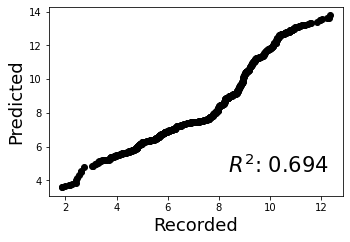

In [29]:
Approved_date = '2020-11-30'
df_future_85= RCP(df_RCP85_MACA,df_AI,Model,8.5,saveRCP_85)
df_future_85.describe()

df_future_85.to_excel(saveRCP_85+str('/df_future_RCP85.xlsx'))

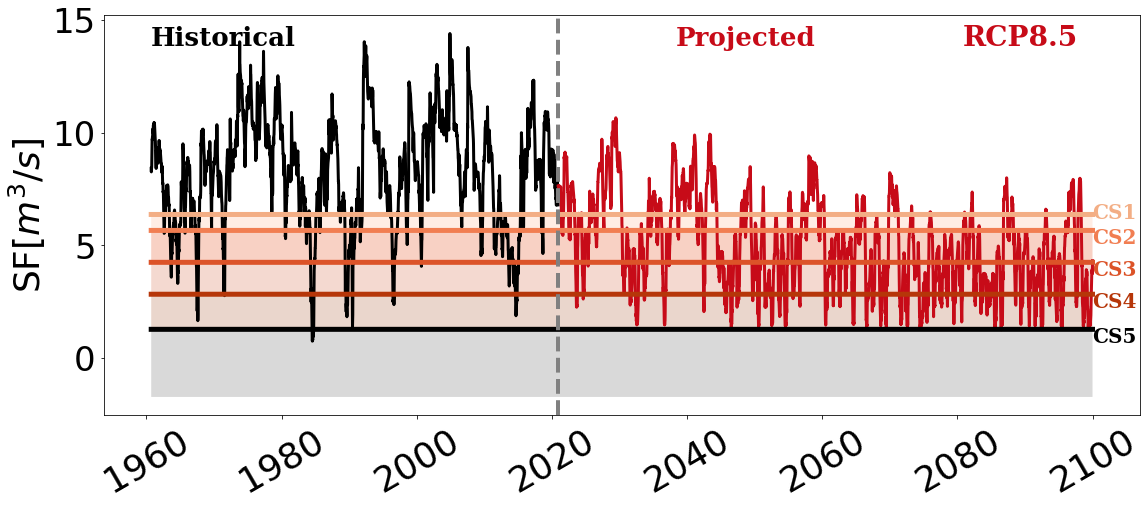

In [30]:
plot_projections(df_future_85,df_AI,8.5,saveRCP_85)

# Terraclimate 

In [31]:
df_AI2 = pd.DataFrame()

df_AI2['$T_{min}$ [$^oC$]'] = df_hist_climate_NOAA['$T_{min}$ [$^oC$]'].resample('M').mean()
df_AI2['$T_{max}$ [$^oC$]'] = df_hist_climate_NOAA['$T_{max}$ [$^oC$]'].resample('M').mean()
df_AI2['$P$ [mm]'] = df_hist_climate_NOAA['$P$ [mm]'].resample('M').sum()

df_AI2 = (df_AI2[(df_AI2.index>='1960-09-01')&(df_AI2.index <= '2019-12-31')])
df_AI2

df_AI2.describe()

,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm]
count,712.000000,712.000000,712.000000
mean,14.746564,26.721704,67.532250
std,7.170900,6.664130,68.030336
min,-0.250896,11.326165,0.000000
25%,8.232527,20.873656,18.478500
50%,15.175926,27.546296,48.768000
75%,21.833333,32.652778,90.805000
max,25.806452,38.620072,458.978000


In [40]:
# TerraClimate Data at Cibolo
base_dir = os.getcwd()+r"/Input_Data/TerraClimate_Data/"
###################################################################################################
filename = r"ETa_CibolaNC_TerraClimate.csv"
df_ETa = read_tabular_data(filename, base_dir)
df_ETa = df_ETa.rename(columns = \
                       {'(mm) Actual ET (TerraClimate) at -98.7092E,29.7839N, 1958-01-01 to 2019-12-31' : \
                        '$ET$ [mm]'})

df_ETa.index = pd.DatetimeIndex(df_ETa['DateTime'])
df_ETa.drop('DateTime',axis=1,inplace=True)

###################################################################################################

###################################################################################################
filename = r"Sm_CibolaNC_TerraClimate.csv"
df_Sm = read_tabular_data(filename, base_dir)
df_Sm = df_Sm.rename(columns = \
                       {'(mm) Soil Moisture (TerraClimate) at -98.7092E,29.7839N, 1958-01-01 to 2019-12-31' : \
                        'SM [mm]'})


df_Sm.index = pd.DatetimeIndex(df_Sm['DateTime'])
df_Sm.drop('DateTime',axis=1,inplace=True)
###################################################################################################



# df_CibolaNC = pd.concat([df_Rd,df_Ta,df_Pr,df_u2,df_ETo,df_ETa,df_Sm,df_Rw],axis=1)
df_Terraclimate = pd.concat([df_ETa,df_Sm],axis=1)
df_Terraclimate.interpolate(method = 'linear', limit_direction = 'both', inplace =True)


In [41]:

df_Terraclimate = df_Terraclimate[(df_Terraclimate.index >= "1960-09") &( df_Terraclimate.index <= '2019-12-31')]

df_Terraclimate

,$ET$ [mm],SM [mm]
DateTime,,
1960-09-01,23.7,22.8
1960-10-01,115.5,119.4
1960-11-01,54.6,102.6
1960-12-01,63.4,135.8
1961-01-01,41.4,118.5
...,...,...
2019-08-01,32.8,37.9
2019-09-01,34.8,32.3
2019-10-01,110.4,30.8


In [42]:


#Data is Transformed to  Monthly mean from daily data and truncated 
SF_Data = Comal_sf_data.resample('M').mean()
SF_Data

df_AI2['SF$[m^3/s]$'] = (SF_Data[(SF_Data.index >= '1960-09-01') & (SF_Data.index <= '2019-12-01')])
df_AI2

df_AI2['$SM$ [mm]'] = df_Terraclimate['SM [mm]'].to_numpy()
df_AI2['$ET$ [mm]'] = df_Terraclimate['$ET$ [mm]'].to_numpy()
df_AI2.describe()

,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm],Month,$T_{max}^{lag1}$ [$^oC$],$T_{max}^{lag2}$ [$^oC$],$T_{min}^{lag1}$ [$^oC$],$T_{min}^{lag2}$ [$^oC$],$P^{lag1}$ [mm],$P^{lag2}$ [mm],SF$[m^3/s]$,$SM$ [mm],$ET$ [mm]
count,712.000000,712.000000,712.000000,712.000000,711.000000,710.000000,711.000000,710.000000,711.000000,710.000000,711.000000,712.000000,712.000000
mean,14.746564,26.721704,67.532250,6.522472,26.730755,26.738487,14.759188,14.768160,67.608655,67.677406,8.284436,63.092416,67.823315
std,7.170900,6.664130,68.030336,3.458746,6.664441,6.665947,7.168026,7.169083,68.047651,68.070908,2.410893,54.370524,39.225814
min,-0.250896,11.326165,0.000000,1.000000,11.326165,11.326165,-0.250896,-0.250896,0.000000,0.000000,0.927548,7.700000,1.200000
25%,8.232527,20.873656,18.478500,4.000000,20.895417,20.886777,8.247354,8.244048,18.669000,18.605500,6.668336,21.875000,38.850000
50%,15.175926,27.546296,48.768000,7.000000,27.555556,27.568100,15.185185,15.212963,48.768000,48.895000,8.474000,43.100000,62.050000
75%,21.833333,32.652778,90.805000,10.000000,32.657407,32.662037,21.833333,21.833333,90.932000,91.059000,10.036823,88.025000,92.250000
max,25.806452,38.620072,458.978000,12.000000,38.620072,38.620072,25.806452,25.806452,458.978000,458.978000,13.627033,238.200000,183.800000


In [43]:
df_AI2 = df_AI2.iloc[:-1,:]

In [44]:
df_AI2

,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm],Month,$T_{max}^{lag1}$ [$^oC$],$T_{max}^{lag2}$ [$^oC$],$T_{min}^{lag1}$ [$^oC$],$T_{min}^{lag2}$ [$^oC$],$P^{lag1}$ [mm],$P^{lag2}$ [mm],SF$[m^3/s]$,$SM$ [mm],$ET$ [mm]
DATE,,,,,,,,,,,,,
1960-09-30,19.074074,32.703704,19.304,9,NaN,NaN,NaN,NaN,NaN,NaN,8.472433,22.8,23.7
1960-10-31,17.652330,28.154122,199.136,10,32.703704,NaN,19.074074,NaN,19.304,NaN,8.814839,119.4,115.5
1960-11-30,11.907407,21.611111,33.020,11,28.154122,32.703704,17.652330,19.074074,199.136,19.304,9.769200,102.6,54.6
1960-12-31,5.232975,14.910394,75.438,12,21.611111,28.154122,11.907407,17.652330,33.020,199.136,10.063226,135.8,63.4
1961-01-31,2.795699,14.910394,17.272,1,14.910394,21.611111,5.232975,11.907407,75.438,33.020,10.218677,118.5,41.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31,23.691756,35.000000,3.556,7,32.907407,29.713262,22.277778,20.340502,139.954,83.820,9.830452,46.0,33.4
2019-08-31,25.501792,37.383513,7.874,8,35.000000,32.907407,23.691756,22.277778,3.556,139.954,8.453097,37.9,32.8
2019-09-30,23.962963,35.851852,36.830,9,37.383513,35.000000,25.501792,23.691756,7.874,3.556,8.548833,32.3,34.8


In [45]:
df_AI2

,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm],Month,$T_{max}^{lag1}$ [$^oC$],$T_{max}^{lag2}$ [$^oC$],$T_{min}^{lag1}$ [$^oC$],$T_{min}^{lag2}$ [$^oC$],$P^{lag1}$ [mm],$P^{lag2}$ [mm],SF$[m^3/s]$,$SM$ [mm],$ET$ [mm]
DATE,,,,,,,,,,,,,
1960-09-30,19.074074,32.703704,19.304,9,NaN,NaN,NaN,NaN,NaN,NaN,8.472433,22.8,23.7
1960-10-31,17.652330,28.154122,199.136,10,32.703704,NaN,19.074074,NaN,19.304,NaN,8.814839,119.4,115.5
1960-11-30,11.907407,21.611111,33.020,11,28.154122,32.703704,17.652330,19.074074,199.136,19.304,9.769200,102.6,54.6
1960-12-31,5.232975,14.910394,75.438,12,21.611111,28.154122,11.907407,17.652330,33.020,199.136,10.063226,135.8,63.4
1961-01-31,2.795699,14.910394,17.272,1,14.910394,21.611111,5.232975,11.907407,75.438,33.020,10.218677,118.5,41.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31,23.691756,35.000000,3.556,7,32.907407,29.713262,22.277778,20.340502,139.954,83.820,9.830452,46.0,33.4
2019-08-31,25.501792,37.383513,7.874,8,35.000000,32.907407,23.691756,22.277778,3.556,139.954,8.453097,37.9,32.8
2019-09-30,23.962963,35.851852,36.830,9,37.383513,35.000000,25.501792,23.691756,7.874,3.556,8.548833,32.3,34.8


In [46]:
# Pumping patterns is hypothesized to be associated with the month
df_AI2['Month'] = df_AI2.index.month 

# There could be some lag effects in the hydroclimatic behavior for Karst aquifers
df_AI2['$T_{max}^{lag1}$ [$^oC$]'] = df_AI2['$T_{max}$ [$^oC$]'].shift(1)
df_AI2['$T_{max}^{lag2}$ [$^oC$]'] = df_AI2['$T_{max}$ [$^oC$]'].shift(2)

df_AI2['$T_{min}^{lag1}$ [$^oC$]'] = df_AI2['$T_{min}$ [$^oC$]'].shift(1)
df_AI2['$T_{min}^{lag2}$ [$^oC$]'] = df_AI2['$T_{min}$ [$^oC$]'].shift(2)

df_AI2['$P^{lag1}$ [mm]'] = df_AI2['$P$ [mm]'].shift(1)
df_AI2['$P^{lag2}$ [mm]'] = df_AI2['$P$ [mm]'].shift(2)

df_AI2['SF$^{lag1} [m^3/s]$'] = df_AI2['SF$[m^3/s]$'].shift(1)
df_AI2['SF$^{lag2} [m^3/s]$'] = df_AI2['SF$[m^3/s]$'].shift(2)

df_AI2.dropna(inplace=True)


In [47]:

Features = ['Month','$T_{min}$ [$^oC$]','$T_{max}$ [$^oC$]','$P$ [mm]',
            '$P^{lag1}$ [mm]','$P^{lag2}$ [mm]','$SM$ [mm]','$ET$ [mm]',
            'SF$^{lag1} [m^3/s]$','SF$^{lag2} [m^3/s]$']

#SpringFlow for Comal = Target
Target = ['SF$[m^3/s]$']


#Take the tain set till 2005 and test set from 2006 till 2020

df_AI2_Train = df_AI2[:'2008-12-31']
df_AI2_Test = df_AI2['2009-01-01':]

#Create Independent and dependent variable for machine learning
X = df_AI2[Features].to_numpy()
Y = df_AI2[Target].to_numpy()
test_X = df_AI2_Test[Features].iloc[0].to_numpy().reshape(1, -1)

In [48]:
train_X = df_AI2_Train[Features].to_numpy()
y_train = df_AI2_Train[Target].to_numpy()


Model = Model.fit(train_X, y_train)

RMS = np.sqrt(mean_squared_error(y_train,Model.predict(train_X)))
RSQ = r2_score(y_train,Model.predict(train_X))
MAE = np.mean(np.abs((y_train -Model.predict(train_X)))) 
NSEe = NSE(Model.predict(train_X),y_train)


print("############ Model Accuracy -Training set ############")
print("MAE: %0.3f" % MAE,'m/s^3')
print("NSE: %0.3f" % NSEe)
print("RMS: %0.3f" % RMS, 'm/s^3')
print("R-squared: %0.3f" % RSQ)
print("########################################")
print(" ")


Learning rate set to 0.037546
0:	learn: 2.3147730	total: 1.27ms	remaining: 1.27s
1:	learn: 2.2515141	total: 2.16ms	remaining: 1.08s
2:	learn: 2.1902583	total: 3.06ms	remaining: 1.01s
3:	learn: 2.1358441	total: 4ms	remaining: 996ms
4:	learn: 2.0785877	total: 4.88ms	remaining: 970ms
5:	learn: 2.0253411	total: 5.83ms	remaining: 967ms
6:	learn: 1.9755513	total: 6.91ms	remaining: 980ms
7:	learn: 1.9285686	total: 7.55ms	remaining: 936ms
8:	learn: 1.8794361	total: 8.51ms	remaining: 937ms
9:	learn: 1.8337718	total: 24.4ms	remaining: 2.41s
10:	learn: 1.7844432	total: 26.2ms	remaining: 2.36s
11:	learn: 1.7406135	total: 27.4ms	remaining: 2.26s
12:	learn: 1.6953788	total: 29.1ms	remaining: 2.21s
13:	learn: 1.6593004	total: 31.5ms	remaining: 2.22s
14:	learn: 1.6181840	total: 33ms	remaining: 2.17s
15:	learn: 1.5779632	total: 35.5ms	remaining: 2.18s
16:	learn: 1.5430671	total: 36.5ms	remaining: 2.11s
17:	learn: 1.5036819	total: 37.6ms	remaining: 2.05s
18:	learn: 1.4706846	total: 40.5ms	remaining: 2.0

In [49]:

##################################################################
# Make predictions on Testing data and Test model accuracy
###################################################################
df_AI2_Test['SF$^{pred} [m^3/s]$'] = 0
Test_X = df_AI2_Test[Features].iloc[0].to_numpy().reshape(1, -1)
df_AI2_Test['SF$^{pred} [m^3/s]$'].iloc[0] = Model .predict(Test_X)[0]

i = 0
for row in df_AI2_Test.itertuples():
    df_AI2_Test['SF$^{lag1} [m^3/s]$'][i+1] = df_AI2_Test['SF$^{pred} [m^3/s]$'].iloc[i] 
    df_AI2_Test['SF$^{lag2} [m^3/s]$'][i+1] = df_AI2_Test['SF$^{lag1} [m^3/s]$'].iloc[i]  
    Test_X = df_AI2_Test[Features].iloc[i+1].to_numpy().reshape(1, -1)
    df_AI2_Test['SF$^{pred} [m^3/s]$'].iloc[i+1] = Model.predict(Test_X)[0]
    i = i+1
    if i == (len(df_AI2_Test)-1):
        break
RMS = np.sqrt(mean_squared_error(df_AI2_Test['SF$[m^3/s]$'].sort_values(ascending=True).to_numpy(),
                  df_AI2_Test['SF$^{pred} [m^3/s]$'].sort_values(ascending=True).to_numpy()))
RSQ = r2_score(df_AI2_Test['SF$[m^3/s]$'].sort_values(ascending=True).to_numpy(),
               df_AI2_Test['SF$^{pred} [m^3/s]$'].sort_values(ascending=True).to_numpy())
MAE = np.mean(np.abs(df_AI2_Test['SF$[m^3/s]$'].sort_values(ascending=True).to_numpy() - 
                     df_AI2_Test['SF$^{pred} [m^3/s]$'].sort_values(ascending=True).to_numpy()))

NSEe = he.evaluator(he.nse,df_AI2_Test['SF$^{pred} [m^3/s]$'].sort_values(ascending=True).tolist(),
          df_AI2_Test['SF$[m^3/s]$'].sort_values(ascending=True).tolist())
print("############ Model Accuracy -Test set############")
print("MAE: %0.3f" % MAE,'m/s^3')
print("NSE: %0.3f" % NSEe)
print("R-squared: %0.3f" % RSQ)
print("RMS: %0.3f" % RMS, 'm/s^3')
print("########################################")
print(" ")


############ Model Accuracy -Test set############
MAE: 0.654 m/s^3
NSE: 0.901
R-squared: 0.901
RMS: 0.747 m/s^3
########################################
 


In [50]:
Model

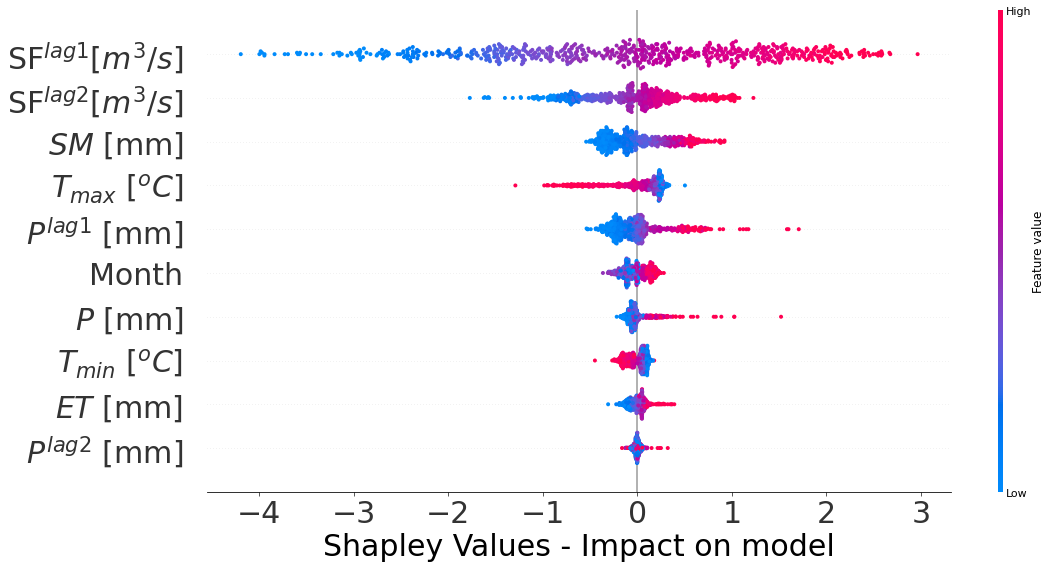

In [51]:
explainer = shap.TreeExplainer(Model)
shap_values = explainer.shap_values(df_AI2[Features].to_numpy())

shap.summary_plot(shap_values, df_AI2[Features].to_numpy(), Features, plot_size=(16,8), show=False)
plt.xlabel('Shapley Values - Impact on model', fontsize=30)
plt.tick_params(labelsize=30)
plt.tight_layout(pad=1.08)
plt.savefig(save_Model +str('/Feature Importance ET-SM- SF.pdf'), format='pdf', dpi=300, bbox_inches ='tight')

Learning rate set to 0.038778
0:	learn: 2.3428838	total: 1.24ms	remaining: 1.24s
1:	learn: 2.2742886	total: 2.7ms	remaining: 1.35s
2:	learn: 2.2159314	total: 4.07ms	remaining: 1.35s
3:	learn: 2.1594833	total: 5.66ms	remaining: 1.41s
4:	learn: 2.0997900	total: 6.92ms	remaining: 1.38s
5:	learn: 2.0464806	total: 8.29ms	remaining: 1.37s
6:	learn: 1.9976687	total: 9.82ms	remaining: 1.39s
7:	learn: 1.9520045	total: 11.8ms	remaining: 1.46s
8:	learn: 1.8976799	total: 15.2ms	remaining: 1.67s
9:	learn: 1.8470254	total: 17.7ms	remaining: 1.75s
10:	learn: 1.7941965	total: 20.1ms	remaining: 1.81s
11:	learn: 1.7474343	total: 22.7ms	remaining: 1.87s
12:	learn: 1.7013932	total: 24.8ms	remaining: 1.88s
13:	learn: 1.6605289	total: 30.3ms	remaining: 2.13s
14:	learn: 1.6186555	total: 31.7ms	remaining: 2.08s
15:	learn: 1.5767316	total: 33.1ms	remaining: 2.03s
16:	learn: 1.5356704	total: 34.3ms	remaining: 1.98s
17:	learn: 1.4943166	total: 35.7ms	remaining: 1.95s
18:	learn: 1.4592950	total: 36.8ms	remaining:

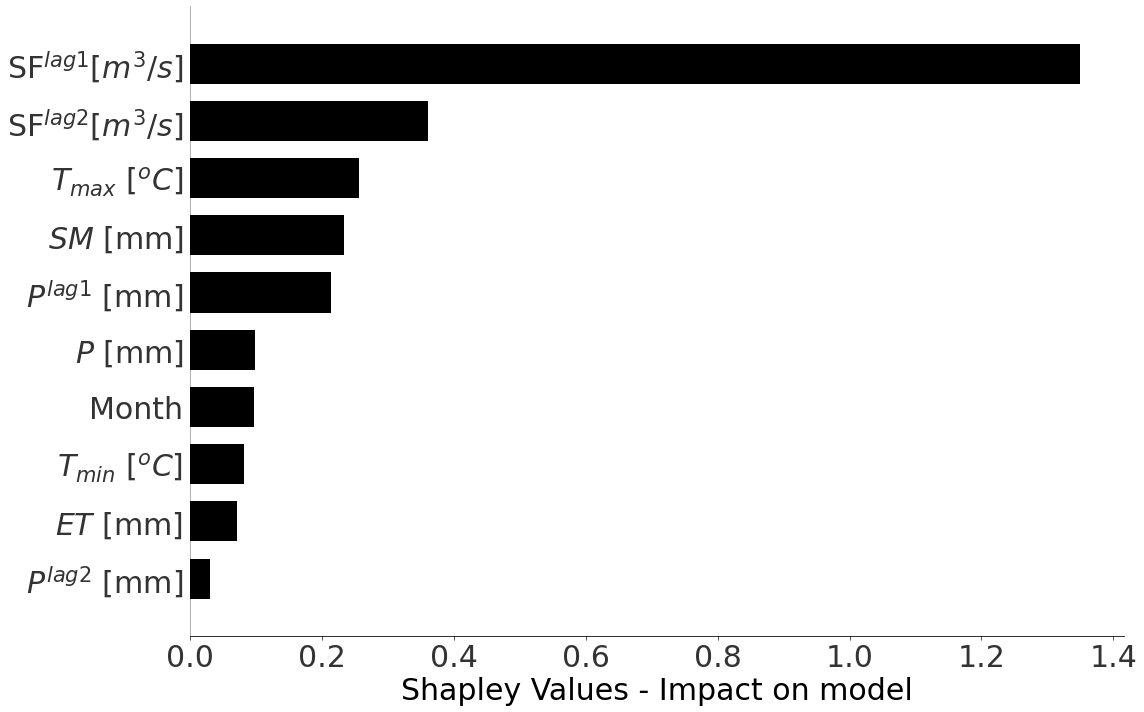

In [52]:
#################################################################################################
# Update Model SpringFLow Model
#################################################################################################20
#With the whole data from 1946 -2020
Model = Model.fit(X, Y)

explainer = shap.TreeExplainer(Model)
shap_values = explainer.shap_values(df_AI2[Features].to_numpy())

shap.summary_plot(shap_values, df_AI2[Features].to_numpy(), Features, plot_size=(16,10), show=False, 
                  plot_type = "bar", color = "black")
plt.xlabel('Shapley Values - Impact on model', fontsize=30)
plt.tick_params(labelsize=30)
plt.tight_layout(pad=1.08)
plt.savefig(save_Model + str('/Feature Importances SMET- SF_Comal - Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


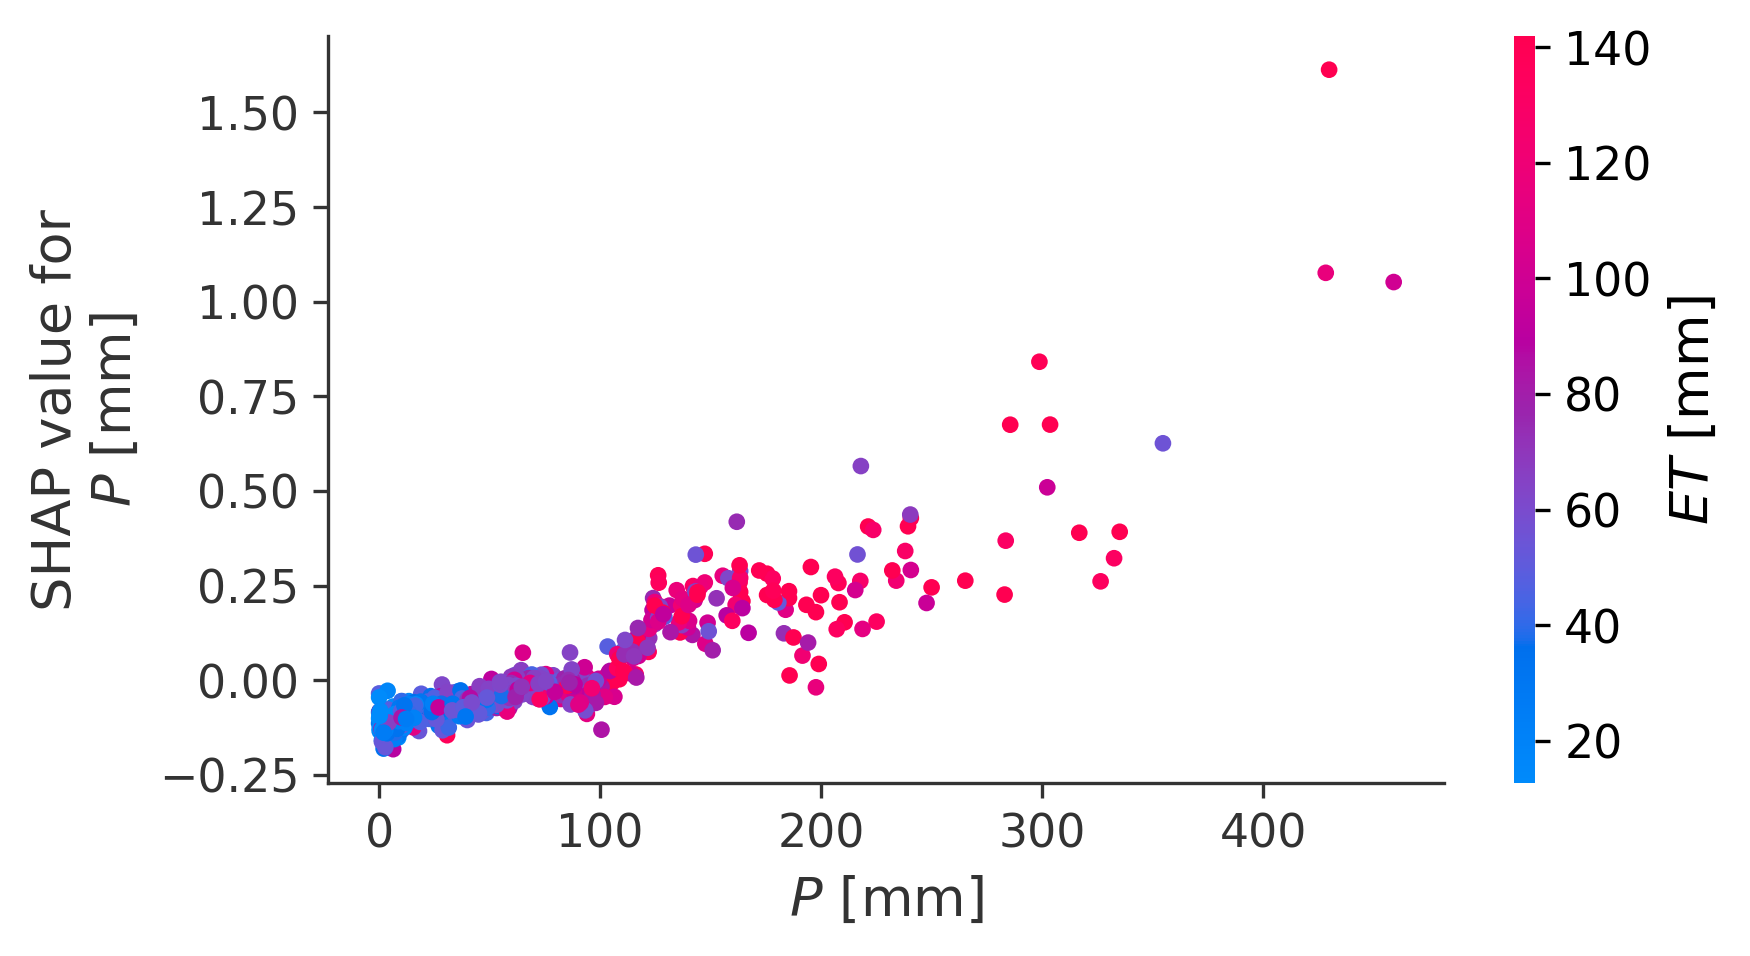

In [53]:
fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot('$P$ [mm]',shap_values, df_AI2[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index='$ET$ [mm]')
plt.savefig(save_Model +str('/Feature Interaction_comal_springs  - Pr-ET2 -Comal Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


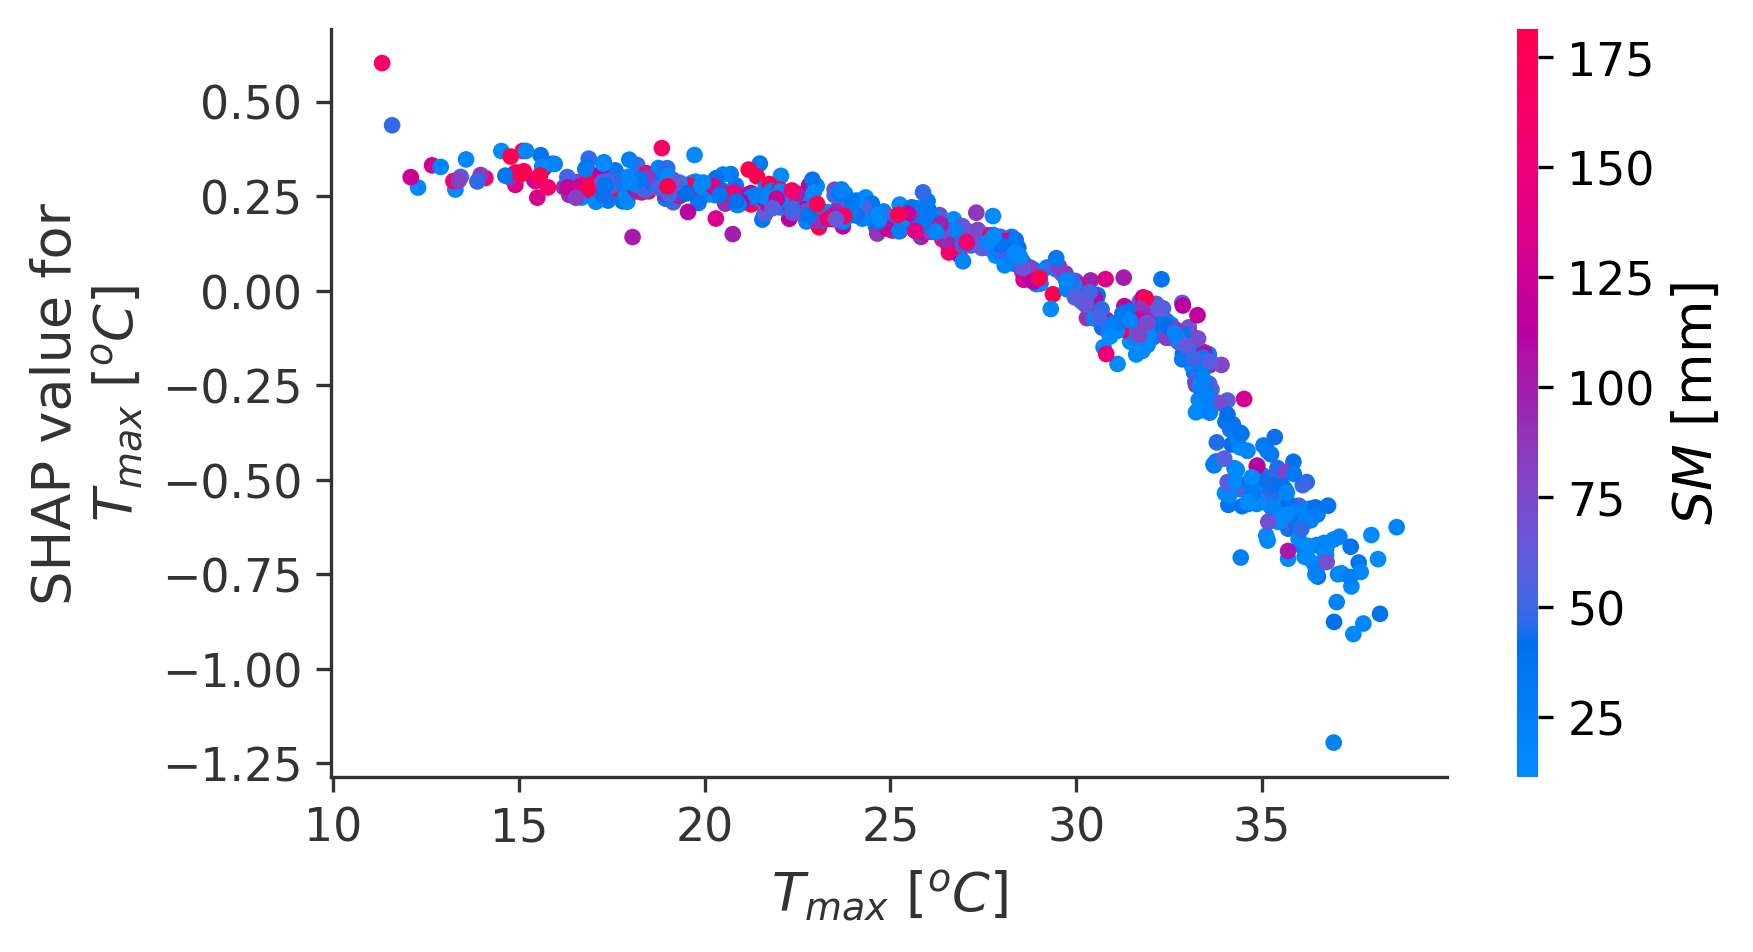

In [54]:

fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot('$T_{max}$ [$^oC$]', shap_values, df_AI2[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index='$SM$ [mm]')
plt.savefig(save_Model +str('/Feature Interaction_comal_springs - Tmax2 - Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')
